In [1]:
import torch
import math
# import chime
from data_loader import NEFG3x3Set
from LVAE import LVAE

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

device = torch.device(dev) 
# torch.cuda.set_device(0) 
# Download the MNIST Dataset
dataset = NEFG3x3Set("info_dat_charge.csv",
                     "data/3x12_16_damp00", "dat_charge", transform=True)

length = len(dataset)
train_split = math.floor(length*.7)
test_split = length - train_split

train_inds, test_inds = torch.utils.data.random_split(
    dataset, [train_split, test_split], generator=torch.Generator().manual_seed(42))


# Model Initialization
model = LVAE(1, [8, 16, 32, 64], [8, 16, 32, 64], kernel=5,  padding=0, stride=1).to(dev)

# Validation using MSE Loss function
# loss_function = torch.nn.L1Loss()

# Using an Adam Optimizer with lr = 0.
optimizer = torch.optim.SGD(model.parameters(),
                             lr=1e-4)

train_data = torch.utils.data.DataLoader(dataset=train_inds, batch_size=32,
                                         shuffle=True)
test_data = torch.utils.data.DataLoader(dataset=test_inds, batch_size=32,
                                        shuffle=True)


In [2]:
epochs = 50
outputs = []
losses = []
local_loss  = 0
txt1 = "Epoch {epoch} / "+str(epochs)
txt2 = "Average training loss: {loss}"
txt3 = "Average test loss: {loss}"


for epoch in range(epochs):
    if epoch%10==0:
        clear_output(wait=True)
    print(txt1.format(epoch = epoch))
    kl_loss = 0

    for (inp,_ , tar, _,_,_) in train_data:
        model.train()
        inp = inp.float()
        tar = tar.float()
        # Output of Autoencoder
        rec = model(tar)
        # print(rec[1])

        # plt.imshow(reconstructed[0].cpu().detach().numpy().reshape(71,-1))
        # plt.show()
        # Calculating the loss function
        loss = model.loss_function(rec[0],rec[1], rec[2],M_N=3)
        # print(loss['loss'])
        local_loss=local_loss+loss['loss']
        optimizer.zero_grad()
        loss['loss'].backward()
        optimizer.step()
        kl_loss+=loss['KLD'].item() 
        
    
    print(txt2.format(loss = local_loss/len(train_data)))
    print(kl_loss/len(test_data))

    losses.append(local_loss/len(test_data))

    local_loss = 0
    for (inp, cmpr,tar, _,_,_) in test_data:
        model.eval()
        
        inp = inp.float()
        tar = tar.float()
        
        # Output of Autoencoder
        rec = model(tar)

        # Calculating the loss function
        loss = model.loss_function(rec[0],rec[1], rec[2], M_N=3)



        local_loss=local_loss+loss['loss'].item()

    
    print(txt3.format(loss = local_loss/len(test_data)))
    
    
    local_loss = 0



Epoch 40 / 50
Average training loss: 0.028165167197585106
-0.008194745416403748
Average test loss: 0.029059977503493428
Epoch 41 / 50
Average training loss: 0.026965970173478127
-0.007980188027431723
Average test loss: 0.027900956280063838
Epoch 42 / 50
Average training loss: 0.025820719078183174
-0.007785829242493492
Average test loss: 0.025223441538400948
Epoch 43 / 50
Average training loss: 0.024722520262002945
-0.007563950272015063
Average test loss: 0.02463024278404191
Epoch 44 / 50
Average training loss: 0.023777969181537628
-0.0074194710978190415
Average test loss: 0.02408087532967329
Epoch 45 / 50
Average training loss: 0.022874407470226288
-0.007266249995154794
Average test loss: 0.022980901005212218
Epoch 46 / 50
Average training loss: 0.0219411738216877
-0.007083311862515984
Average test loss: 0.02197267848532647
Epoch 47 / 50
Average training loss: 0.021089401096105576
-0.0069118577521294355
Average test loss: 0.020487950707320124
Epoch 48 / 50
Average training loss: 0.0203

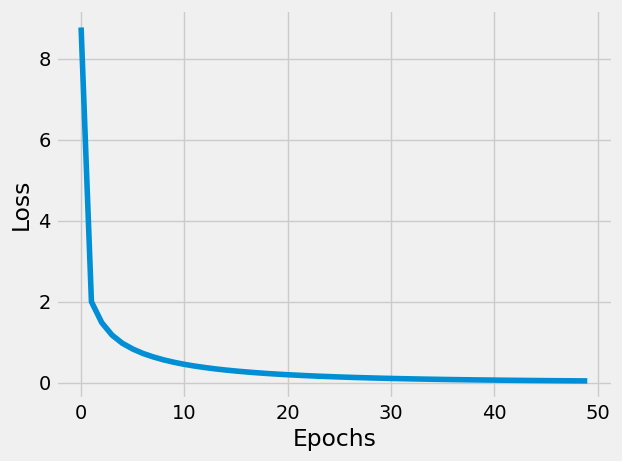

In [3]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Plotting the last 100 values
a = [i.cpu().detach().numpy() for i in losses]

plt.plot(a)
plt.show()

In [4]:
Lf = torch.nn.MSELoss()

loss_og =0
loss_cmp=0
loss_inp=0
test_data = torch.utils.data.DataLoader(dataset=test_inds, batch_size=1,
                                        shuffle=True)
model.eval()

for (inp, cmpr,tar, _,_,_) in test_data:
    
    inp = inp.reshape(1,1,71,26).float()
    cmpr = cmpr.reshape(1,1,71,26).float()
    tar = tar.reshape(1, 1,71,26).float()
    # print(inp.shape)
    rec = model(tar)[0].float().reshape(1, 1,71, 26)
    
    loss_inp += Lf(tar, inp).item()
    loss_cmp += Lf(tar, cmpr).item()
    loss_og += Lf(tar, rec).item()
    
print(loss_inp/len(dataset))
print(loss_og/len(dataset))
print(loss_cmp/len(dataset))

# 0.04133150164104515
# 1e-5


6.192370868955924e-05
0.0032165258195239674
1.0669039261460472e-05


In [5]:
torch.save(model.state_dict(), "trained_models/conv")

# Notes

Do a full deivice
